In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from icecream import ic
import jx_lib

ic| FILE_PATH: '/home/jx/JX_Project/data/dr-dataset/train-(crop__[320, 320])/10569_right.jpeg'
    np.shape(img): (320, 320, 3)
ic| FILE_PATH2: '/home/jx/JX_Project/data/dr-dataset/train/10569_right.jpeg'
    np.shape(img2): (2592, 3888, 3)


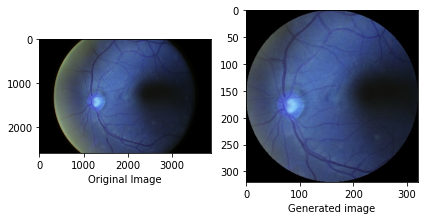

In [2]:
## USER DEFINED:
ABS_PATH = "/home/jx/JX_Project/affordable-DR-monitoring/data-analysis/" # Define ur absolute path here
DATA_DIRECTORY = "/home/jx/JX_Project/data/dr-dataset/"

## Custom Files:
def abspath(relative_path):
    return os.path.join(ABS_PATH, relative_path)

def abs_data_path(relative_path):
    return os.path.join(DATA_DIRECTORY, relative_path)


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(abspath("src"))

import jx_lib
import jx_pytorch_lib

file_name = "10569_right"

FILE_PATH = abs_data_path("train-(crop__[320, 320])/{}.jpeg".format(file_name))
img = cv2.imread(FILE_PATH)

FILE_PATH2 = abs_data_path("train/{}.jpeg".format(file_name))
img2 = cv2.imread(FILE_PATH2)

ic(FILE_PATH, np.shape(img))
ic(FILE_PATH2, np.shape(img2))

fig=jx_lib.imgs_plot(
    dict_of_imgs={
        "Original Image" : img2,
        "Generated image" : img,
        # "output_image_aug" : output_image_aug,
    },
    OUT_DIR=abspath("output"),
    tag="test",
    show=True
)


ic| prop_first.bbox: (0, 0, 320, 320)
ic| h: 320
    w: 320
    c: 3
    height: 320
    width: 320
    cx: 160
    cy: 160
    R_min: 150
ic| np.shape(Cropped_image): (300, 300, 3)


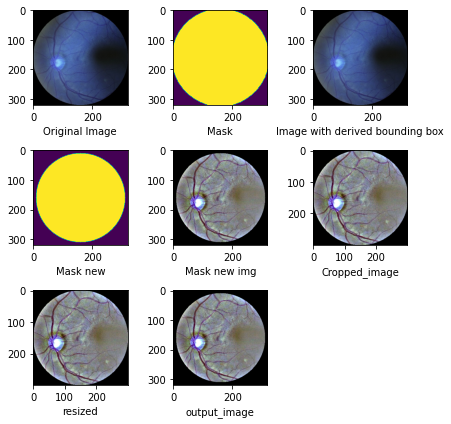

In [3]:
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops

import jx_lib
# Reload:
# import importlib
# importlib.reload(jx_lib)


### Find Bounding Box
img_gray =  cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img2 =  cv2.GaussianBlur(img_gray, (11, 11), 0)

img_0 = img
mask_0 = img2 > 1

h,w,c = np.shape(img_0)
lbl_0 = label(mask_0) 
props = regionprops(lbl_0)
img_1 = img_0.copy()

if len(props) == 0:
    assert("Error Finding A Bounding Box")

prop_first = props[0]
ic(prop_first.bbox)

(y0, x0, y1, x1) = prop_first.bbox

height = y1 - y0
width = x1 - x0
cy = int(h/2) if height == h else int(y0+(height)/2) 
cx = int(w/2) if width == w else int(x0+(width)/2)
R_min = int(min(height, width)/2) - 10

ic(h,w,c, height, width, cx, cy, R_min)

### Apply Filters On Original Dataset: (Trick on competition)
img_0_aug = cv2.addWeighted(img_0,4, cv2.GaussianBlur(img_0 , (0,0) , R_min/10) ,-4 ,128)

### Circular Cropping
# Circular Cropping
mask = np.zeros((h, w), dtype=np.uint8)
cv2.circle(mask,(cx, cy),R_min,255,-1)
masked_img = cv2.bitwise_and(img_0_aug,img_0_aug,mask = mask)

# Remap
Cropped_image = masked_img[cy-R_min:cy+R_min, cx-R_min:cx+R_min, :]
ic(np.shape(Cropped_image))

EYE_SIZE = (300,300)
FINAL_SIZE = (320,320,3) 

resize_image = cv2.resize(Cropped_image, EYE_SIZE, interpolation=cv2.INTER_LINEAR)

# add padding
output_image = np.zeros(FINAL_SIZE, dtype=np.uint8)
output_image[10:310,10:310,:] = resize_image

# Cropped_image = img_0
#
fig=jx_lib.imgs_plot(
    dict_of_imgs={
        "Original Image" : img_0,
        "Mask"  : mask_0,
        "Image with derived bounding box" : img_1,
        "Mask new" : mask,
        "Mask new img" : masked_img,
        "Cropped_image" : Cropped_image,
        "resized" : resize_image,
        "output_image" : output_image,
        # "output_image_aug" : output_image_aug,
    },
    OUT_DIR=abspath("output"),
    tag="test",
    show=True
)